In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
# from mpl_toolkits.mplot3d import Axes3D
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.manifold import TSNE
import umap
from sklearn.cluster import KMeans
import seaborn as sns
from tqdm import tqdm
from scipy.interpolate import interp1d

# VAE 1D + 2D (spectrogram)

In [2]:
folder_name = "AOI_100hz_50ms_pre_end_bin" # stacked to 27

### Load all data

In [3]:
all_data = True

In [4]:
data_dir = os.path.join("M:", "neuro2voc", "task-5", "dtw", "spectrogram")

data_files = []
for f in os.listdir(data_dir):
    if f.endswith('.npy'):
        num = int(f.split('_')[1])  # Extract the number after 'spec_'
        data_files.append((num, f))

data_files.sort()  # This will sort based on the number
data_files = [f[1] for f in data_files]  # Keep just the filenames

sorted_data = []
labels = []

# Load data and labels in order
for file in tqdm(data_files, desc="Loading data and labels"):
    label = int(file.split('_')[3])  # Get label from filename
    data_path = os.path.join(data_dir, file)
    data = np.load(data_path)
    
    sorted_data.append(data)
    labels.append(label)

Loading data and labels: 100%|██████████| 3459/3459 [00:15<00:00, 228.80it/s]


In [5]:
# Find max shape across all samples
max_shape = max([sample.shape for sample in sorted_data], key=lambda x: x[0]*x[1])
print(f"Max shape: {max_shape}")

max_time = max_shape[1]
print(f"Max time: {max_time}")

Max shape: (128, 56)
Max time: 56


In [6]:
# # Convert labels to tensor and save
# labels_tensor = torch.tensor(labels)
# torch.save(labels_tensor, 'training_data/all_labels.pt')

### Sort one label

In [ ]:
# all_data = False

In [3]:
# data_dir = os.path.join("M:", "neuro2voc", "task-5", "dtw", "spectrogram")

# # Get list of all .npy files and sort them
# data_files = sorted([f for f in os.listdir(data_dir) if f.endswith('.npy')])

# yourLabel = 2
# data_list = []

# # Load only data for specified label
# for file in tqdm(data_files, desc="Loading data and labels"):
#     label = int(file.split('_')[3])
#     if label == yourLabel:
#         data_path = os.path.join(data_dir, file)
#         data = np.load(data_path)
#         data_list.append(data)

# # Store as numpy arrays since data sizes differ
# sorted_data = {yourLabel: data_list}

Loading data and labels: 100%|██████████| 3459/3459 [00:02<00:00, 1426.79it/s]


In [137]:
# print(f"Number of samples for class {yourLabel}:")
# print(f"Class {yourLabel}: {len(sorted_data[yourLabel])} samples")
# print(f"Sample shapes:")
# for i, sample in enumerate(sorted_data[yourLabel][:3]):
#     print(f"Sample {i}: {sample.shape}")

# # Print max shape
# max_shape = max([sample.shape for sample in sorted_data[yourLabel]], key=lambda x: x[0]*x[1])

# max_time = max_shape[1]
# print(f"\nMax time: {max_time}")

Number of samples for class 2:
Class 2: 472 samples
Sample shapes:
Sample 0: (128, 12)
Sample 1: (128, 12)
Sample 2: (128, 11)

Max time: 26


## Shape warping

In [7]:
class SpectrogramWarper:
    def __init__(self, target_time_points, spec_bins=128):
        self.target_time_points = target_time_points
        self.interp1d = interp1d
    
    def warp(self, spectrogram):
        # [freq_bins, time_points]
        if spectrogram.shape[0] != spec_bins:
            spectrogram = spectrogram.T
            
        freq_bins, time_points = spectrogram.shape
        
        orig_times = np.linspace(0, 1, time_points)
        target_times = np.linspace(0, 1, self.target_time_points)
        
        # interpolate for each freq bin
        warped = np.zeros((freq_bins, self.target_time_points))
        for i in range(freq_bins):
            interp_func = self.interp1d(orig_times, spectrogram[i], 
                                      kind='linear', bounds_error=False,
                                      fill_value=(spectrogram[i, 0], spectrogram[i, -1]))
            warped[i] = interp_func(target_times)
            
        return warped

In [8]:
spec_bins = 128
warper = SpectrogramWarper(target_time_points=max_time, spec_bins=spec_bins)

# Warp all spectrograms to max_time
warped_spectrograms = []
for spec in sorted_data:
    warped = warper.warp(spec)
    warped_spectrograms.append(warped)

# Convert to tensor 
warped_data = torch.stack([torch.from_numpy(spec) for spec in warped_spectrograms])

In [9]:
print(f"Shape of warped_data before saving: {warped_data.shape}")

Shape of warped_data before saving: torch.Size([3459, 128, 56])


In [16]:
import os

save_dir = 'training_data'

# Check shape before saving
save_path = os.path.join(save_dir, 'data_warped_speech.pt')
torch.save(warped_data, save_path)

In [17]:
print(f"Original data shape for label {yourLabel}: {sorted_data[yourLabel][0].shape}")  # [128, varying_time]
print(f"Warped data shape: {warped_data.shape}")  #  [n_samples, 128, 26]

NameError: name 'yourLabel' is not defined

In [18]:
print("Warped data info:")
print(f"Shape: {warped_data.shape}")
print(f"Type: {warped_data.dtype}")
print(f"Device: {warped_data.device}")
print(f"Min value: {warped_data.min():.4f}")
print(f"Max value: {warped_data.max():.4f}")

Warped data info:
Shape: torch.Size([3459, 128, 56])
Type: torch.float64
Device: cpu
Min value: 45.0000
Max value: 120.0000


In [22]:
if not all_data:
    labels = torch.tensor([yourLabel] * len(warped_data))
    print(f"Labels shape: {labels.shape}")
else:
    print("All data. no labels are created")

All data. no labels are created


# Model

In [6]:
# Load the warped data and labels
warped_data = torch.load('training_data/data_warped_speech.pt', weights_only=True)
labels = torch.load('training_data/all_labels.pt', weights_only=True)
all_data = True
print(f"Loaded warped data shape: {warped_data.shape}")
print(f"Loaded labels shape: {labels.shape}")
max_time = warped_data.shape[2]
print(f"Max time: {max_time}")


Loaded warped data shape: torch.Size([3459, 128, 56])
Loaded labels shape: torch.Size([3459])
Max time: 56


In [7]:
class VAE(nn.Module):
    def __init__(self, input_channels, input_length, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.input_channels = input_channels
        self.input_length = input_length
        
        self.encoder = nn.Sequential(
            nn.Conv1d(input_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * input_length, hidden_dim),
            nn.ReLU()
        )
        
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 64 * input_length),
            nn.ReLU(),
            nn.Unflatten(1, (64, input_length)),
            nn.ConvTranspose1d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(32, input_channels, kernel_size=3, padding=1)
        )
        
    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

    def loss_function(self, recon_x, x, mu, logvar):
        MSE = F.mse_loss(recon_x, x, reduction='sum')
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return MSE + 0.1 * KLD

In [8]:
class VAE2D(nn.Module):
    def __init__(self, input_channels=1, height=75, width=27, hidden_dim=256, latent_dim=32):
        super(VAE2D, self).__init__()
        
        h1, w1 = (height + 2*1 - 3)//2 + 1, (width + 2*1 - 3)//2 + 1     # 38, 14
        h2, w2 = (h1 + 2*1 - 3)//2 + 1, (w1 + 2*1 - 3)//2 + 1           # 19, 7
        h3, w3 = (h2 + 2*1 - 3)//2 + 1, (w2 + 2*1 - 3)//2 + 1           # 10, 4

        self.final_h = h3
        self.final_w = w3
        self.final_channels = 64
        self.flatten_size = self.final_channels * self.final_h * self.final_w
        
        # Encoder
        self.encoder_conv = nn.Sequential(
            # Input processing
            nn.BatchNorm2d(input_channels),
            
            # Block 1: (1, 75, 27) -> (16, 75, 27) -> (16, 38, 14)
            nn.Conv2d(input_channels, 16, 3, 1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, 2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            
            # Block 2: (16, 38, 14) -> (32, 38, 14) -> (32, 19, 7)
            nn.Conv2d(16, 32, 3, 1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, 2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            # Block 3: (32, 19, 7) -> (64, 19, 7) -> (64, 10, 4)
            nn.Conv2d(32, 64, 3, 1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, 2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        
        # Flatten layer
        self.flatten = nn.Flatten()
        
        # Feature processing
        self.encoder_fc = nn.Sequential(
            nn.Linear(self.flatten_size, 1024),  
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
        )
        
        # Latent space
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)
        
        # Decoder
        self.decoder_fc = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 1024),
            nn.ReLU(),
            nn.Linear(1024, self.flatten_size),
            nn.ReLU(),
        )
        
        print("Initializing decoder convolutional layers")
        self.decoder_conv = nn.Sequential(
            # Block 1: (64, 10, 4) -> (32, 31, 7)
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
     
            # Block 2: (32, 19, 7) -> (16, 38, 14)
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            
            # Final: (16, 38, 14) -> (1, 75, 27)
            nn.ConvTranspose2d(16, input_channels, kernel_size=3, stride=2, padding=1, output_padding=0),
        )
        self.final_adjust = nn.AdaptiveAvgPool2d((height, width))
    
    def encode(self, x):
        if len(x.shape) == 3:
            x = x.unsqueeze(1)
        # print(f"Input shape: {x.shape}") 
        
        h = self.encoder_conv(x)
        # print(f"After conv: {h.shape}") 
        
        h = self.flatten(h)
        # print(f"After flatten: {h.shape}") 

        h = self.encoder_fc(h)
        # print(f"After FC: {h.shape}") 
        
        return self.fc_mu(h), self.fc_logvar(h)
    
    def decode(self, z):
        h = self.decoder_fc(z)
        h = h.view(-1, self.final_channels, self.final_h, self.final_w)
        h = self.decoder_conv(h)
        h = self.final_adjust(h)
        return h
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

    def loss_function(self, recon_x, x, mu, logvar, beta=0.1):
        if len(x.shape) == 3:
            x = x.unsqueeze(1)
        
        recon_loss = F.mse_loss(recon_x, x, reduction='mean')
        kld_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        total_loss = recon_loss + beta * kld_loss
        
        return total_loss, recon_loss, kld_loss

# Parameters

In [9]:
choice = "2D"

### Device

In [10]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda


### Dataloader

In [11]:
warped_data = warped_data.float()

if choice == "2D" and len(warped_data.shape) == 3:
    print(f"data has been unsqueezed from {warped_data.shape} to {warped_data.unsqueeze(1).shape}")
    warped_data = warped_data.unsqueeze(1)
    
if all_data:
    dataset = TensorDataset(warped_data)
else:
    dataset = TensorDataset(warped_data, labels)
dataloader = DataLoader(dataset, batch_size=2048, shuffle=True)

data has been unsqueezed from torch.Size([3459, 128, 56]) to torch.Size([3459, 1, 128, 56])


### Hyperparameters

In [12]:
learning_rate = 2e-4
num_epochs = 20000
patience = 1000
min_delta = 1e-5

### Model and optimizer

In [13]:
if choice == "2D":
    model = VAE2D(
        input_channels=1,
        height=128,
        width=max_time,
        hidden_dim=256,
        latent_dim=32
    ).to(device)
elif choice == "1D":
    model = VAE(
        input_channels=128,
        input_length=max_time,
        hidden_dim=256,
        latent_dim=32
    ).to(device)

Initializing decoder convolutional layers


In [14]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

### Early stopping

In [15]:
best_loss = float('inf')
patience_counter = 0
best_model = None

### Training function

In [27]:
def train(model, train_loader, num_epochs, learning_rate, patience, min_delta, device):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    best_loss = float('inf')
    patience_counter = 0
    best_model = None

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch in train_loader:
            x = batch[0].float().to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(x)
            loss = model.loss_function(recon_batch, x, mu, logvar)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
            if torch.isnan(loss) or torch.isinf(loss):
                print("Loss is NaN or Inf. Stopping training.")
                return model, epoch

        avg_loss = total_loss / len(train_loader.dataset)
        print(f'Epoch {epoch + 1}, Loss: {avg_loss:.4f}')

        # Early stopping check
        if avg_loss < best_loss - min_delta:
            best_loss = avg_loss
            patience_counter = 0
            best_model = model.state_dict()
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs")
            break

    # Load the best model
    if best_model is not None:
        model.load_state_dict(best_model)

    return model, epoch

In [28]:
def train2D(model, train_loader, num_epochs, learning_rate, patience=5, min_delta=0.01, device='cuda'):

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    best_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        total_recon_loss = 0
        total_kld_loss = 0
        n_batches = 0
        
        for batch in train_loader:
            x = batch[0].float().to(device)
            optimizer.zero_grad()
            
            recon_batch, mu, logvar = model(x)
            total_loss_batch, recon_loss_batch, kld_loss_batch = model.loss_function(recon_batch, x, mu, logvar)
            
            total_loss_batch.backward()
            optimizer.step()
            
            total_loss += total_loss_batch.item()
            total_recon_loss += recon_loss_batch.item()
            total_kld_loss += kld_loss_batch.item()
            n_batches += 1
        
        avg_loss = total_loss / n_batches
        avg_recon_loss = total_recon_loss / n_batches
        avg_kld_loss = total_kld_loss / n_batches
        
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Loss: {avg_loss:.4f}, '
              f'Recon Loss: {avg_recon_loss:.4f}, '
              f'KLD Loss: {avg_kld_loss:.4f}')
        
        if avg_loss < best_loss - min_delta:
            best_loss = avg_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping after {epoch + 1} epochs')
                return model, epoch
    
    return model, num_epochs - 1

# Train

In [29]:
if choice == "1D":
    model, epochs_trained = train(model, dataloader, num_epochs, learning_rate, patience, min_delta, device)
elif choice == "2D":
    model, epochs_trained = train2D(model, dataloader, num_epochs, learning_rate, patience, min_delta, device)
print(f"Training completed after {epochs_trained + 1} epochs.")


Epoch [1/20000], Loss: 4320.9712, Recon Loss: 4320.9685, KLD Loss: 0.0276
Epoch [2/20000], Loss: 4317.5752, Recon Loss: 4317.5410, KLD Loss: 0.3427
Epoch [3/20000], Loss: 4309.0298, Recon Loss: 4308.9104, KLD Loss: 1.1934
Epoch [4/20000], Loss: 4304.4778, Recon Loss: 4304.1909, KLD Loss: 2.8694
Epoch [5/20000], Loss: 4297.3076, Recon Loss: 4296.7986, KLD Loss: 5.0891
Epoch [6/20000], Loss: 4296.5496, Recon Loss: 4295.8752, KLD Loss: 6.7410
Epoch [7/20000], Loss: 4293.5557, Recon Loss: 4292.8538, KLD Loss: 7.0182
Epoch [8/20000], Loss: 4292.6387, Recon Loss: 4292.0259, KLD Loss: 6.1263
Epoch [9/20000], Loss: 4289.0615, Recon Loss: 4288.5798, KLD Loss: 4.8167
Epoch [10/20000], Loss: 4290.1089, Recon Loss: 4289.7397, KLD Loss: 3.6900
Epoch [11/20000], Loss: 4287.6711, Recon Loss: 4287.3752, KLD Loss: 2.9591
Epoch [12/20000], Loss: 4288.2041, Recon Loss: 4287.9473, KLD Loss: 2.5681
Epoch [13/20000], Loss: 4280.8257, Recon Loss: 4280.5842, KLD Loss: 2.4159
Epoch [14/20000], Loss: 4280.6787,

In [30]:
# Save the best model
if choice == "2D":
    save_path = "training_data/model_speech_2dvae.pt"
    torch.save(model.state_dict(), save_path)
    print(f"Model saved to {save_path}")

Model saved to training_data/model_speech_2dvae.pt


# Visualize the result

In [16]:
# Load the saved model
if choice == "2D":
    save_path = "training_data/model_speech_2dvae.pt"
    model.load_state_dict(torch.load(save_path))
    print(f"Model loaded from {save_path}")

Model loaded from training_data/model_speech_2dvae.pt


C:\Users\askrb\AppData\Local\Temp\ipykernel_35832\846442956.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


In [17]:
# Load the warped data and labels
# warped_data = torch.load('training_data/data_warped_speech.pt', weights_only=True)
# labels = torch.load('training_data/all_labels.pt', weights_only=True)
# print(f"Loaded warped data shape: {warped_data.shape}")
# print(f"Loaded labels shape: {labels.shape}")

device = next(model.parameters()).device
stacked_data = warped_data.to(device)#.float() 

# 2D

In [43]:
# Create output directory if it doesn't exist
import os
import numpy as np
output_dir = "visualization_results/2d_speech_warped_vae/"
os.makedirs(output_dir, exist_ok=True)

# Get unique labels
unique_labels = torch.unique(labels)

for label in unique_labels:
    # Get indices for current label
    label_indices = (labels == label).nonzero().squeeze()
    
    # Pick two occurrences of this label
    for case in range(2):
        selected_idx = label_indices[case]
        selected_data = stacked_data[selected_idx:selected_idx+1]

        with torch.no_grad():
            recon_data, mu, logvar = model(selected_data)
            
            if len(selected_data.shape) == 3:
                selected_data = selected_data.unsqueeze(1)
            
            # Convert to dB scale
            selected_data_db = 20 * torch.log10(selected_data + 1e-10)
            recon_data_db = 20 * torch.log10(recon_data + 1e-10)
            
            # Get value range for consistent colormap scaling
            vmin = selected_data_db[0, 0].cpu().numpy().min()
            vmax = selected_data_db[0, 0].cpu().numpy().max()
            
            # Create figure with two subplots side by side
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 15))
            
            # Original data
            im1 = ax1.imshow(selected_data_db[0, 0].cpu().numpy(), aspect='auto', cmap='viridis',
                           origin='lower', extent=[0, selected_data.shape[-1], 0, 8000],
                           vmin=vmin, vmax=vmax)
            plt.colorbar(im1, ax=ax1, label='Amplitude (dB)')  # Added colorbar for left plot
            ax1.set_title(f'Original Syllable {label.item()}')
            ax1.set_xlabel('Time (ms)')
            ax1.set_ylabel('Frequency (Hz)')
            
            # Reconstructed data
            im2 = ax2.imshow(recon_data_db[0, 0].cpu().numpy(), aspect='auto', cmap='viridis',
                           origin='lower', extent=[0, recon_data.shape[-1], 0, 8000],
                           vmin=vmin, vmax=vmax)
            plt.colorbar(im2, ax=ax2, label='Amplitude (dB)')
            ax2.set_title(f'Reconstructed Syllable {label.item()}')
            ax2.set_xlabel('Time (ms)')
            ax2.set_ylabel('Frequency (Hz)')
            
            plt.tight_layout()
            plt.savefig(f'{output_dir}syllable_{label.item()}_case_{case+1}.pdf',
                       dpi=1200, bbox_inches='tight')
            plt.close()

C:\Users\askrb\AppData\Local\Temp\ipykernel_35832\65329602.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(w_pad=0)


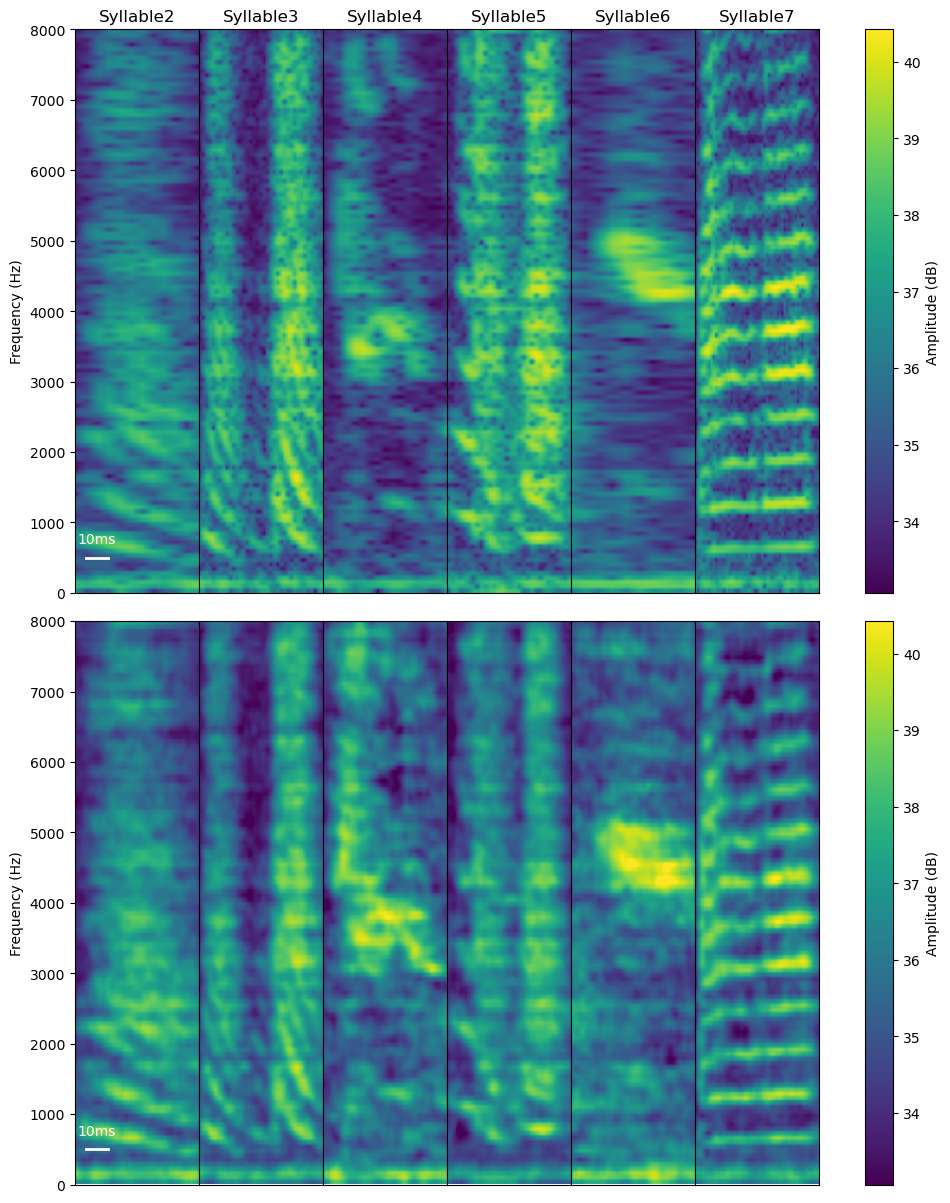

In [74]:
# Create output directory if it doesn't exist
import os
import numpy as np
output_dir = "visualization_results/2d_speech_warped_vae/"
os.makedirs(output_dir, exist_ok=True)

# Get labels 2-7
selected_labels = range(2, 8)

# Create figure with subplots in a row
fig, axes = plt.subplots(2, 6, figsize=(12, 15), gridspec_kw={'wspace': 0, 'hspace': 0.05})

# Initialize lists to track min/max values for each row
vmin_orig = float('inf')
vmax_orig = float('-inf')
vmin_recon = float('inf') 
vmax_recon = float('-inf')

# First pass to get global min/max values
for label in selected_labels:
    label_indices = (labels == label).nonzero().squeeze()
    selected_idx = label_indices[0]
    selected_data = stacked_data[selected_idx:selected_idx+1]

    with torch.no_grad():
        recon_data, mu, logvar = model(selected_data)
        
        if len(selected_data.shape) == 3:
            selected_data = selected_data.unsqueeze(1)
        
        # Convert to dB scale
        selected_data_db = 20 * torch.log10(selected_data + 1e-10)
        recon_data_db = 20 * torch.log10(recon_data + 1e-10)
        
        # Update global min/max values
        vmin_orig = min(vmin_orig, selected_data_db[0, 0].cpu().numpy().min())
        vmax_orig = max(vmax_orig, selected_data_db[0, 0].cpu().numpy().max())
        vmin_recon = min(vmin_recon, recon_data_db[0, 0].cpu().numpy().min())
        vmax_recon = max(vmax_recon, recon_data_db[0, 0].cpu().numpy().max())

# Second pass to plot with consistent scaling
for i, label in enumerate(selected_labels):
    label_indices = (labels == label).nonzero().squeeze()
    selected_idx = label_indices[0]
    selected_data = stacked_data[selected_idx:selected_idx+1]

    with torch.no_grad():
        recon_data, mu, logvar = model(selected_data)
        
        if len(selected_data.shape) == 3:
            selected_data = selected_data.unsqueeze(1)
        
        # Convert to dB scale
        selected_data_db = 20 * torch.log10(selected_data + 1e-10)
        recon_data_db = 20 * torch.log10(recon_data + 1e-10)
        
        # Original data
        im1 = axes[0, i].imshow(selected_data_db[0, 0].cpu().numpy(), aspect='auto', cmap='viridis',
                       origin='lower', extent=[0, selected_data.shape[-1], 0, 8000],
                       vmin=vmin_orig, vmax=vmax_orig)
        if i == 5:  # Only add colorbar for last plot in row
            plt.colorbar(im1, ax=axes[0, :].ravel().tolist(), label='Amplitude (dB)')
        axes[0, i].set_title(f'Syllable{label}')
        if i == 0:  # Only show yticks for leftmost plot
            axes[0, i].set_ylabel('Frequency (Hz)')
            # Add 10ms scale bar
            axes[0, i].plot([5, 15], [500, 500], 'w-', linewidth=2)
            axes[0, i].text(10, 700, '10ms', color='white', ha='center')
        else:
            axes[0, i].set_yticks([])
        axes[0, i].set_xticks([])  # Hide x-axis ticks
        
        # Reconstructed data
        im2 = axes[1, i].imshow(recon_data_db[0, 0].cpu().numpy(), aspect='auto', cmap='viridis',
                       origin='lower', extent=[0, recon_data.shape[-1], 0, 8000], vmin=vmin_orig, vmax=vmax_orig)
        if i == 5:  # Only add colorbar for last plot in row
            plt.colorbar(im2, ax=axes[1, :].ravel().tolist(), label='Amplitude (dB)')
        if i == 0:  # Only show yticks for leftmost plot
            axes[1, i].set_ylabel('Frequency (Hz)')
            # Add 10ms scale bar
            axes[1, i].plot([5, 15], [500, 500], 'w-', linewidth=2)
            axes[1, i].text(10, 700, '10ms', color='white', ha='center')
        else:
            axes[1, i].set_yticks([])
        axes[1, i].set_xticks([])  # Hide x-axis ticks

plt.tight_layout(w_pad=0)
plt.savefig(output_dir+'comparison_plot.pdf', dpi=1200, bbox_inches='tight')
plt.show()

# 1D

torch.Size([1, 128, 26])


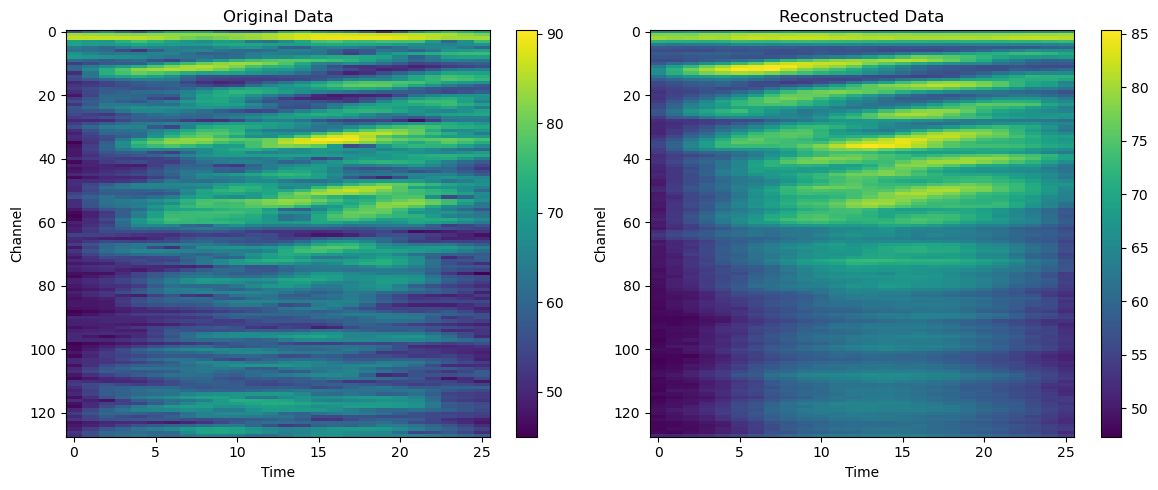

In [103]:
random_indices = torch.randint(0, stacked_data.shape[0], (1,))
selected_data = stacked_data[random_indices]
print(selected_data.shape)
with torch.no_grad():
    latent_embeddings, _ = model.encode(selected_data)
    reconstructed_data = model.decode(latent_embeddings)

plt.figure(figsize=(12, 5))

# Create frequency axis
freq_bins = np.linspace(0, 8000, 128)

# Original data
plt.subplot(121)
plt.imshow(selected_data[0].cpu().numpy(), aspect='auto', cmap='viridis',
          origin='lower', extent=[0, selected_data.shape[-1], 0, 8000])
plt.colorbar()
plt.title('Original Data')
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (Hz)')

# Reconstructed data 
plt.subplot(122)
plt.imshow(reconstructed_data[0].cpu().numpy(), aspect='auto', cmap='viridis',
          origin='lower', extent=[0, reconstructed_data.shape[-1], 0, 8000])
plt.colorbar()
plt.title('Reconstructed Data')
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (Hz)')

plt.tight_layout()
plt.show()

# Evaluation

In [50]:
def evaluate_reconstruction(model, data_loader, device):
    model.eval()
    total_mse = 0
    total_relative_error = 0
    n_samples = 0
    
    with torch.no_grad():
        for batch in data_loader:
            if isinstance(batch, (list, tuple)):
                x = batch[0]
            else:
                x = batch
            x = x.float().to(device)
            
            if len(x.shape) == 3 and isinstance(model, VAE2D):
                x = x.unsqueeze(1)
            
            recon, mu, logvar = model(x)

            mse = F.mse_loss(recon, x, reduction='mean')
            
            # use data range to normalize, avoid division by a value close to 0
            data_range = torch.max(x) - torch.min(x) # this was added
            relative_error = torch.mean(torch.abs(recon - x)) / data_range * 100  # convert to percentage
            
            total_mse += mse.item()
            total_relative_error += relative_error.item()
            n_samples += 1
    
    avg_mse = total_mse / n_samples
    rmse = np.sqrt(avg_mse)
    avg_relative_error = total_relative_error / n_samples
    
    return {
        'MSE': avg_mse,
        'RMSE': rmse,
        'Relative_Error(%)': avg_relative_error
    }

In [51]:
metrics = evaluate_reconstruction(model, dataloader, device)
print("\nReconstruction Quality Metrics:")
print(f"MSE: {metrics['MSE']:.6f}")
print(f"RMSE: {metrics['RMSE']:.6f}")
print(f"Relative Error: {metrics['Relative_Error(%)']:.6f}")


Reconstruction Quality Metrics:
MSE: 11.500376
RMSE: 3.391220
Relative Error: 3.452102


Warpped-1D:
- MSE: 21.984344
- RMSE: 4.688747
- Relative Error: 4.829245


2D - one label

MSE: 1.692240
RMSE: 1.300861
Relative Error: 1.301549

2d - all labels:

Reconstruction Quality Metrics:
MSE: 11.500376
RMSE: 3.391220
Relative Error: 3.452102


In [74]:
def get_latent_embeddings(model, dataloader, device):
    model.eval()
    latent_embeddings = []
    
    # Create sequential dataloader with no shuffling
    sequential_dataloader = torch.utils.data.DataLoader(
        dataloader.dataset,
        batch_size=dataloader.batch_size,
        shuffle=False
    )
    
    with torch.no_grad():
        for batch in sequential_dataloader:
            if isinstance(batch, (list, tuple)):
                x = batch[0]
            else:
                x = batch
            x = x.float().to(device)
            
            if len(x.shape) == 3 and isinstance(model, VAE2D):
                x = x.unsqueeze(1)
            
            mu, _ = model.encode(x)
            latent_embeddings.append(mu.cpu())
    
    return torch.cat(latent_embeddings, dim=0)

speech_embeddings = get_latent_embeddings(model, dataloader, device)
torch.save(speech_embeddings, 'training_data/embedding_2dvae_warpped_speech.pt')

In [76]:
speech_embeddings.shape

torch.Size([472, 32])

In [293]:
speech_embeddings[0]

tensor([ 4.4340e-03,  2.2215e-02, -2.1389e-03,  3.3737e-03,  6.1282e-01,
        -1.8591e+00, -1.7627e-02, -8.3208e-01, -1.1311e+00,  9.9965e-02,
         7.9830e-03, -6.6861e-02,  5.8724e-01,  4.6739e-02, -2.0641e-01,
        -5.8789e-02, -1.7675e-01, -3.2917e-03, -4.5926e-01, -2.8196e-01,
         4.8043e-01, -8.8653e-01,  4.3616e-01,  6.0915e-01,  3.2548e-03,
        -7.2271e-01,  1.6268e+00,  2.3542e-01, -1.4777e-03,  2.3086e+00,
         2.5325e-03,  7.7774e-01])

In [98]:
# Load the embeddings
speech_embeddings = torch.load('training_data/embedding_1dvae_warpped_neural.pt', weights_only=True)
neural_embeddings = torch.load('training_data/embedding_2dvae_warpped_speech.pt', weights_only=True)

# Print shapes
print("Speech embeddings shape:", speech_embeddings.shape)
print("Neural embeddings shape:", neural_embeddings.shape)


Speech embeddings shape: torch.Size([3459, 32])
Neural embeddings shape: torch.Size([3459, 32])


In [99]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Load labels (assuming they are available and match the embeddings order)
# Replace this with actual labels loading if needed
labels = torch.load('training_data/all_labels.pt') 

# Convert embeddings to numpy for sklearn
X = neural_embeddings.numpy()
y = labels

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train SVM classifier
svm = SVC(kernel='rbf', random_state=42)
svm.fit(X_train, y_train)

# Make predictions
y_pred = svm.predict(X_test)

# Print classification metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:", accuracy_score(y_test, y_pred))


C:\Users\askrb\AppData\Local\Temp\ipykernel_9948\3723126900.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load('training_data/all_labels.pt')


Classification Report:
              precision    recall  f1-score   support

           2       0.97      1.00      0.98        95
           3       1.00      1.00      1.00       136
           4       1.00      0.99      1.00       133
           5       1.00      1.00      1.00       117
           6       0.99      1.00      1.00       108
           7       1.00      1.00      1.00       100
           8       0.00      0.00      0.00         3

    accuracy                           0.99       692
   macro avg       0.85      0.86      0.85       692
weighted avg       0.99      0.99      0.99       692


Accuracy Score: 0.9942196531791907


c:\Users\askrb\miniforge3\envs\neuro2voc_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\askrb\miniforge3\envs\neuro2voc_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\askrb\miniforge3\envs\neuro2voc_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

In [97]:
# Assuming:
# speech_embeddings.shape = [472, 32]
# neural_embeddings with same shape
# shared labels

from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Apply PCA to both embeddings
pca_speech = PCA(n_components=2)
pca_neural = PCA(n_components=2)

speech_pca = pca_speech.fit_transform(speech_embeddings)
neural_pca = pca_neural.fit_transform(neural_embeddings)

In [79]:
print(speech_embeddings.shape[1])
print(neural_embeddings.shape[1])

32
32


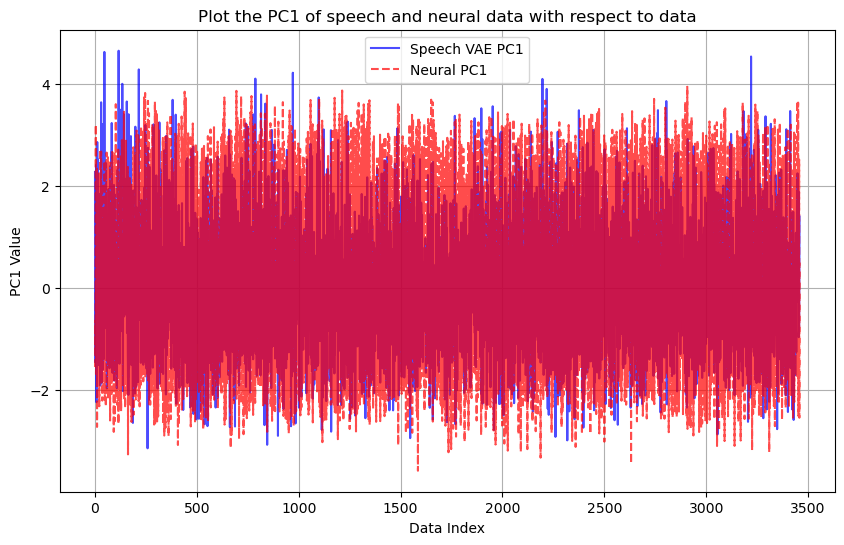

In [80]:
# Single plot for PC1 comparison
plt.figure(figsize=(10, 6))

# Plot both PC1s on the same graph
plt.plot(range(len(speech_pca)), speech_pca[:, 0], 
         label='Speech VAE PC1', color='blue', alpha=0.7)
plt.plot(range(len(neural_pca)), neural_pca[:, 0], 
         label='Neural PC1', color='red', alpha=0.7, linestyle='--')
plt.title('Plot the PC1 of speech and neural data with respect to data')
plt.xlabel('Data Index')
plt.ylabel('PC1 Value')
plt.legend()
plt.grid(True)

plt.show()

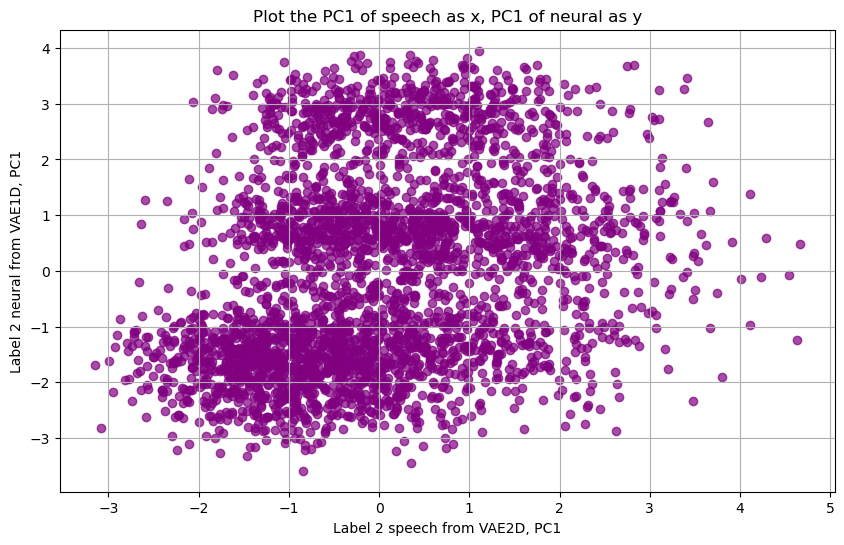

In [82]:
# Scatter plot of PC1s
plt.figure(figsize=(10, 6))

# Plot PC1 of speech vs PC1 of neural
plt.scatter(speech_pca[:, 0], neural_pca[:, 0], 
           alpha=0.7, color='purple')
plt.title('Plot the PC1 of speech as x, PC1 of neural as y')
plt.xlabel('Label 2 speech from VAE2D, PC1')
plt.ylabel('Label 2 neural from VAE1D, PC1')
plt.grid(True)


plt.show()

In [102]:
from sklearn.cross_decomposition import CCA
import numpy as np
from scipy import stats
import os

# Create directory if it doesn't exist
os.makedirs('visualization_results', exist_ok=True)

# Apply CCA
n_components = min(speech_embeddings.shape[1], neural_embeddings.shape[1])
cca = CCA(n_components=n_components)
speech_cca, neural_cca = cca.fit_transform(speech_embeddings, neural_embeddings)

# Calculate explained variance ratio for each component
speech_var_ratio = np.var(speech_cca, axis=0) / np.sum(np.var(speech_cca, axis=0))
neural_var_ratio = np.var(neural_cca, axis=0) / np.sum(np.var(neural_cca, axis=0))

print("Variance explained and correlations for each component:")
print("-" * 50)

# Create plots and calculate statistics for each component
for i in range(6):
    # Calculate regression statistics
    slope, intercept, r_value, p_value, std_err = stats.linregress(speech_cca[:, i], neural_cca[:, i])
    
    # Print statistics
    print(f"\nComponent {i+1}:")
    print(f"Speech variance explained: {speech_var_ratio[i]:.3f}")
    print(f"Neural variance explained: {neural_var_ratio[i]:.3f}")
    print(f"Correlation (R): {r_value:.3f}")
    print(f"R-squared: {r_value**2:.3f}")
    
    # Create and save plot
    plt.figure(figsize=(10, 6))
    
    # Plot scatter and regression line
    plt.scatter(speech_cca[:, i], neural_cca[:, i], alpha=0.3)
    line_x = np.array([speech_cca[:, i].min(), speech_cca[:, i].max()])
    line_y = slope * line_x + intercept
    plt.plot(line_x, line_y, color='red', 
            label=f'R² = {r_value**2:.3f}')
    
    plt.xlabel(f'Speech CC {i+1}')
    plt.ylabel(f'Neural CC {i+1}')
    plt.title(f'Canonical Correlation {i+1}\n' + 
             f'Variance: Speech {speech_var_ratio[i]:.3f}, Neural {neural_var_ratio[i]:.3f}')
    plt.grid(True)
    plt.legend()
    
    # Save plot
    plt.savefig(f'visualization_results/CCA-{i+1}.png', bbox_inches='tight', dpi=300)
    plt.close()

print("\nCumulative variance explained:")
print(f"Speech (first 5 components): {np.cumsum(speech_var_ratio)[:5]}")
print(f"Neural (first 5 components): {np.cumsum(neural_var_ratio)[:5]}")

Variance explained and correlations for each component:
--------------------------------------------------

Component 1:
Speech variance explained: 0.043
Neural variance explained: 0.086
Correlation (R): 0.727
R-squared: 0.529

Component 2:
Speech variance explained: 0.038
Neural variance explained: 0.088
Correlation (R): 0.628
R-squared: 0.395

Component 3:
Speech variance explained: 0.028
Neural variance explained: 0.054
Correlation (R): 0.509
R-squared: 0.259

Component 4:
Speech variance explained: 0.027
Neural variance explained: 0.073
Correlation (R): 0.467
R-squared: 0.218

Component 5:
Speech variance explained: 0.028
Neural variance explained: 0.053
Correlation (R): 0.379
R-squared: 0.144

Component 6:
Speech variance explained: 0.033
Neural variance explained: 0.029
Correlation (R): 0.320
R-squared: 0.103

Cumulative variance explained:
Speech (first 5 components): [0.04257549 0.08038737 0.10832253 0.13508181 0.16316915]
Neural (first 5 components): [0.0856984  0.17332037 0.2

In [104]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
speech_data_scaled = scaler.fit_transform(speech_embeddings)
neural_data_scaled = scaler.fit_transform(neural_embeddings)

from sklearn.decomposition import PCA
pca = PCA(n_components=0.95) 
speech_data_denoised = pca.fit_transform(speech_data_scaled)
neural_data_denoised = pca.fit_transform(neural_data_scaled)

In [105]:
from sklearn.manifold import TSNE

# 使用t-SNE进行非线性降维
tsne = TSNE(n_components=2)
speech_tsne = tsne.fit_transform(speech_embeddings)
neural_tsne = tsne.fit_transform(neural_embeddings)

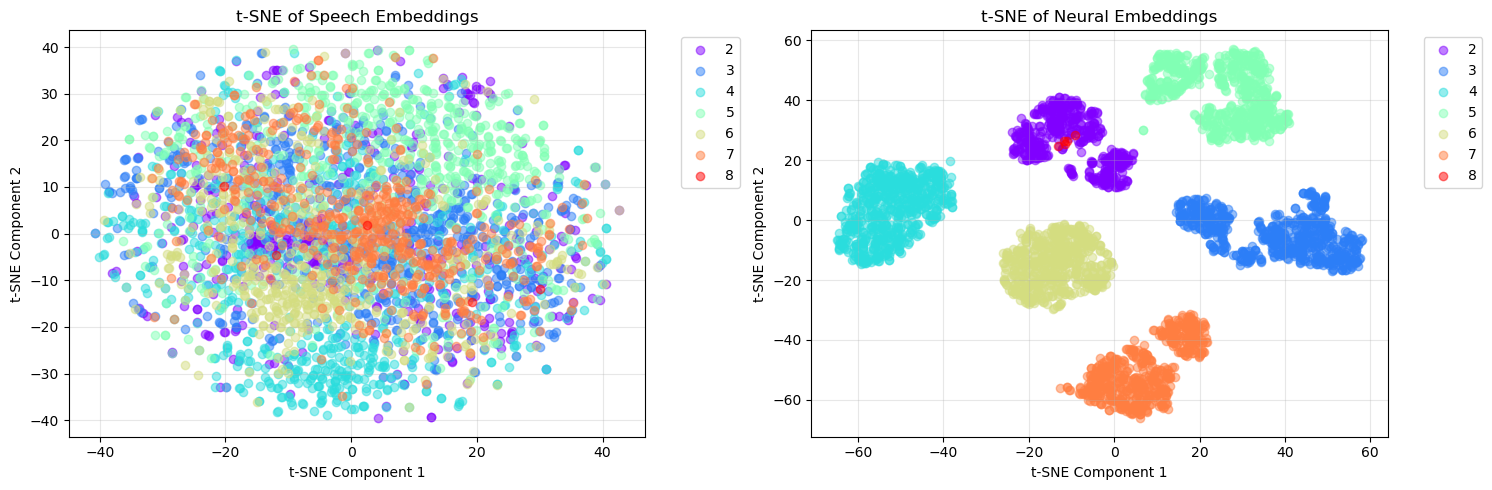


t-SNE Analysis:
Mean distance between corresponding points: 41.762
Std of distances: 20.297
Min distance: 0.623
Max distance: 103.765


: 

In [106]:
# Create a figure to visualize t-SNE results
plt.figure(figsize=(15, 5))

# Create a colormap based on unique labels
unique_labels = np.unique(labels)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
label_to_color = dict(zip(unique_labels, colors))

# Plot speech embeddings t-SNE
plt.subplot(121)
for label in unique_labels:
    mask = labels == label
    plt.scatter(speech_tsne[mask, 0], speech_tsne[mask, 1], 
               c=[label_to_color[label]], label=label, alpha=0.5)
plt.title('t-SNE of Speech Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot neural embeddings t-SNE
plt.subplot(122)
for label in unique_labels:
    mask = labels == label
    plt.scatter(neural_tsne[mask, 0], neural_tsne[mask, 1],
               c=[label_to_color[label]], label=label, alpha=0.5)
plt.title('t-SNE of Neural Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Calculate and print the 2D distances between corresponding points
distances = np.sqrt(np.sum((speech_tsne - neural_tsne)**2, axis=1))
print(f"\nt-SNE Analysis:")
print(f"Mean distance between corresponding points: {np.mean(distances):.3f}")
print(f"Std of distances: {np.std(distances):.3f}")
print(f"Min distance: {np.min(distances):.3f}")
print(f"Max distance: {np.max(distances):.3f}")


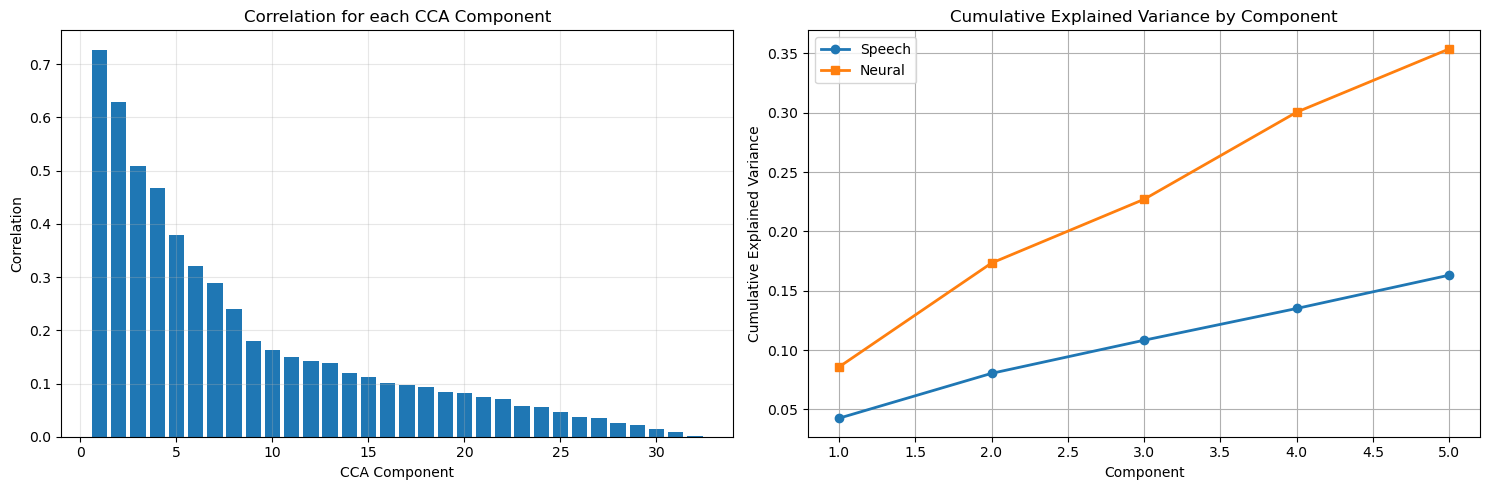


Component Analysis:

Component 1:
Correlation: 0.727
Speech Explained Variance: 0.043
Neural Explained Variance: 0.086

Component 2:
Correlation: 0.628
Speech Explained Variance: 0.080
Neural Explained Variance: 0.173

Component 3:
Correlation: 0.509
Speech Explained Variance: 0.108
Neural Explained Variance: 0.227

Component 4:
Correlation: 0.467
Speech Explained Variance: 0.135
Neural Explained Variance: 0.301

Component 5:
Correlation: 0.379
Speech Explained Variance: 0.163
Neural Explained Variance: 0.354


In [88]:
correlations = []
for i in range(n_components):
    corr = np.corrcoef(speech_cca[:, i], neural_cca[:, i])[0,1]
    correlations.append(corr)
plt.figure(figsize=(15, 5))

# 1. 相关性
plt.subplot(121)
plt.bar(range(1, n_components+1), correlations)
plt.xlabel('CCA Component')
plt.ylabel('Correlation')
plt.title('Correlation for each CCA Component')
plt.grid(True, alpha=0.3)

# 2. Explained Variance
plt.subplot(122)
plt.plot(range(1, 6), speech_var, 'o-', label='Speech', linewidth=2)
plt.plot(range(1, 6), neural_var, 's-', label='Neural', linewidth=2)
plt.xlabel('Component')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Component')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 打印详细信息
print("\nComponent Analysis:")
for i in range(min(5, n_components)):
    print(f"\nComponent {i+1}:")
    print(f"Correlation: {correlations[i]:.3f}")
    print(f"Speech Explained Variance: {speech_var[i]:.3f}")
    print(f"Neural Explained Variance: {neural_var[i]:.3f}")

# Neural model

In [294]:
data_dir = os.path.join("M:", "neuro2voc", "task-5", folder_name, "data")
label_dir = os.path.join("M:", "neuro2voc", "task-5", folder_name, "labels")

data_files = sorted([f for f in os.listdir(data_dir) if f.endswith('.npy')])
data_list = []
label_list = []

for file in tqdm(data_files, desc="Loading data and labels"):
    # read in data
    data_path = os.path.join(data_dir, file)
    data = np.load(data_path)
    
    # read in label
    label_path = os.path.join(label_dir, file)
    label = np.load(label_path)

    if label == yourLabel:
        data_list.append(data)
        label_list.append(label)



max_length = max(data.shape[1] for data in data_list)
assert all(data.shape[0] == 75 for data in data_list), "All data should have 75 neurons"

target_time_points = max_length
interp_data_list = []

for data in data_list:
    orig_times = np.linspace(0, 1, data.shape[1])
    target_times = np.linspace(0, 1, target_time_points)
    
    # interpolate for each neuron
    interp_data = np.zeros((data.shape[0], target_time_points))
    for i in range(data.shape[0]):
        interp_func = interp1d(orig_times, data[i], kind='linear', bounds_error=False,
                               fill_value=(data[i, 0], data[i, -1]))
        interp_data[i] = interp_func(target_times)
    
    interp_data_list.append(interp_data)

# tensor
padded_data = [torch.tensor(data, dtype=torch.float32) for data in interp_data_list]
labels = [torch.tensor(label, dtype=torch.long).unsqueeze(0) for label in label_list]

# stack
stacked_data = torch.stack(padded_data, dim=0)
stacked_labels = torch.cat(labels, dim=0)

print(f"Shape of stacked data: {stacked_data.shape}")
print(f"Shape of stacked labels: {stacked_labels.shape}")

Loading data and labels: 100%|██████████| 3459/3459 [00:01<00:00, 3369.89it/s]


Shape of stacked data: torch.Size([472, 75, 15])
Shape of stacked labels: torch.Size([472])


In [295]:
class VAE1DNeural(nn.Module):
    def __init__(self, input_channels, input_length, hidden_dim, latent_dim):
        super(VAE1DNeural, self).__init__()
        self.input_channels = input_channels
        self.input_length = input_length
        
        self.encoder = nn.Sequential(
            nn.Conv1d(input_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * input_length, hidden_dim),
            nn.ReLU()
        )
        
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 64 * input_length),
            nn.ReLU(),
            nn.Unflatten(1, (64, input_length)),
            nn.ConvTranspose1d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(32, input_channels, kernel_size=3, padding=1)
        )
        
    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

    def loss_function(self, recon_x, x, mu, logvar):
        MSE = F.mse_loss(recon_x, x, reduction='sum')
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return MSE + 0.1 * KLD

In [297]:
dataset = TensorDataset(stacked_data, stacked_labels)
dataloader = DataLoader(dataset, batch_size=4096, shuffle=True)
learning_rate = 3e-4
num_epochs = 1000000
patience = 1000
min_delta = 1e-5
model_neural = VAE1DNeural(
        input_channels=75,
        input_length=max_length,
        hidden_dim=256,
        latent_dim=32
    ).to(device)

In [298]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
best_loss = float('inf')
patience_counter = 0
best_model = None
model_neural, epochs_trained = train(model_neural, dataloader, num_epochs, learning_rate, patience, min_delta, device)

Epoch 1, Loss: 514.4150
Epoch 2, Loss: 511.6522
Epoch 3, Loss: 509.0133
Epoch 4, Loss: 506.4888
Epoch 5, Loss: 503.9222
Epoch 6, Loss: 501.4646
Epoch 7, Loss: 498.9193
Epoch 8, Loss: 496.1284
Epoch 9, Loss: 492.9445
Epoch 10, Loss: 489.8297
Epoch 11, Loss: 486.4462
Epoch 12, Loss: 482.2823
Epoch 13, Loss: 478.4032
Epoch 14, Loss: 473.3479
Epoch 15, Loss: 467.6368
Epoch 16, Loss: 462.0364
Epoch 17, Loss: 455.2491
Epoch 18, Loss: 447.9116
Epoch 19, Loss: 439.7008
Epoch 20, Loss: 430.9168
Epoch 21, Loss: 421.9079
Epoch 22, Loss: 413.3512
Epoch 23, Loss: 407.2996
Epoch 24, Loss: 404.6735
Epoch 25, Loss: 402.1940
Epoch 26, Loss: 396.4082
Epoch 27, Loss: 387.6633
Epoch 28, Loss: 379.5583
Epoch 29, Loss: 373.2624
Epoch 30, Loss: 367.9236
Epoch 31, Loss: 363.3904
Epoch 32, Loss: 358.4980
Epoch 33, Loss: 353.6737
Epoch 34, Loss: 347.9940
Epoch 35, Loss: 341.9326
Epoch 36, Loss: 336.2984
Epoch 37, Loss: 331.2771
Epoch 38, Loss: 326.5729
Epoch 39, Loss: 321.8143
Epoch 40, Loss: 317.9671
Epoch 41,

# Train latent mapper

In [407]:
class LatentMapper(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LatentMapper, self).__init__()
        
        self.mapper = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),
            
            nn.Linear(128, output_dim)
        )
    
    def forward(self, x):
        return self.mapper(x)

def train_mapper(neural_embeddings, speech_embeddings, batch_size=64, num_epochs=10000, learning_rate=0.0001):
    dataset = TensorDataset(neural_embeddings, speech_embeddings)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    input_dim = neural_embeddings.shape[1]
    output_dim = speech_embeddings.shape[1]
    mapper = LatentMapper(input_dim, output_dim).to(device)
    
    optimizer = optim.AdamW(mapper.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    
    for epoch in range(num_epochs):
        mapper.train()
        total_loss = 0
        
        for neural_batch, speech_batch in dataloader:
            neural_batch = neural_batch.to(device)
            speech_batch = speech_batch.to(device)
            
            predicted_speech_embeddings = mapper(neural_batch)
            loss = criterion(predicted_speech_embeddings, speech_batch)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(dataloader):.4f}')
    
    return mapper


In [408]:
neural_embeddings = torch.load('1dvae_warpped_neural_embeddings.pt', weights_only=True)
speech_embeddings = torch.load('2dvae_warpped_speech_embeddings.pt', weights_only=True)

In [409]:
import torch.optim as optim

In [410]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mapper = train_mapper(neural_embeddings, speech_embeddings, num_epochs=5000, learning_rate=0.005)

Epoch [10/5000], Loss: 0.4985
Epoch [20/5000], Loss: 0.4020
Epoch [30/5000], Loss: 0.3569
Epoch [40/5000], Loss: 0.3246
Epoch [50/5000], Loss: 0.3010
Epoch [60/5000], Loss: 0.2800
Epoch [70/5000], Loss: 0.2654
Epoch [80/5000], Loss: 0.2625
Epoch [90/5000], Loss: 0.2597
Epoch [100/5000], Loss: 0.2500
Epoch [110/5000], Loss: 0.2495
Epoch [120/5000], Loss: 0.2443
Epoch [130/5000], Loss: 0.2324
Epoch [140/5000], Loss: 0.2326
Epoch [150/5000], Loss: 0.2333
Epoch [160/5000], Loss: 0.2304
Epoch [170/5000], Loss: 0.2247
Epoch [180/5000], Loss: 0.2219
Epoch [190/5000], Loss: 0.2190
Epoch [200/5000], Loss: 0.2192
Epoch [210/5000], Loss: 0.2214
Epoch [220/5000], Loss: 0.2184
Epoch [230/5000], Loss: 0.2152
Epoch [240/5000], Loss: 0.2256
Epoch [250/5000], Loss: 0.2093
Epoch [260/5000], Loss: 0.2128
Epoch [270/5000], Loss: 0.2079
Epoch [280/5000], Loss: 0.2072
Epoch [290/5000], Loss: 0.2057
Epoch [300/5000], Loss: 0.1997
Epoch [310/5000], Loss: 0.2010
Epoch [320/5000], Loss: 0.1964
Epoch [330/5000],

In [411]:
torch.save(mapper.state_dict(), 'neuro2voc_latent_mapper.pt')
neuro2voc_mapper = mapper

# Mapping

In [415]:
def test_mapping(mapper, from_vae, to_vae, test_data):
    mapper.eval()
    from_vae.eval()
    to_vae.eval()
    
    with torch.no_grad():
        from_mu, _ = from_vae.encode(test_data)
        predicted_to_embedding = mapper(from_mu)
        generated_speech = to_vae.decode(predicted_to_embedding)
        
        return generated_speech

In [416]:
model_speech = model

In [425]:
# run this if neural to speech
speech_dataset = TensorDataset(warped_data)  
speech_dataloader_ordered = DataLoader(
    speech_dataset,
    batch_size=1,  
    shuffle=False, 
    drop_last=False
)

neural_dataset = TensorDataset(stacked_data) 
neural_dataloader_ordered = DataLoader(
    neural_dataset,
    batch_size=1,  
    shuffle=False,  
    drop_last=False
)

print("Speech data samples:", len(speech_dataset))
print("Neural data samples:", len(neural_dataset))

print("Number of speech batches:", len(speech_dataloader_ordered))
print("Number of neural batches:", len(neural_dataloader_ordered))

# Create iterators
speech_iterator = iter(speech_dataloader_ordered)
neural_iterator = iter(neural_dataloader_ordered)

# Skip first batch
next(speech_iterator)
next(neural_iterator)

# Get next batch (second batch)
speech_batch = next(speech_iterator)
neural_batch = next(neural_iterator)

print("\nBatch shapes:")
print("Speech batch shape:", speech_batch[0].shape)
print("Neural batch shape:", neural_batch[0].shape)

neural_data = neural_batch[0]
speech_data = speech_batch[0]

neural_data = neural_data.to(device)
speech_data = speech_data.to(device)

print(neural_data.shape)
print(speech_data.shape)

generated_speech = test_mapping(neuro2voc_mapper, model_neural, model_speech, neural_data)

Speech data samples: 472
Neural data samples: 472
Number of speech batches: 472
Number of neural batches: 472

Batch shapes:
Speech batch shape: torch.Size([1, 1, 128, 26])
Neural batch shape: torch.Size([1, 75, 15])
torch.Size([1, 75, 15])
torch.Size([1, 1, 128, 26])


In [356]:
# run this if speech to neural

# neural_dataset = TensorDataset(warped_data) 
# neural_dataloader_ordered = DataLoader(
#     neural_dataset,
#     batch_size=1,  
#     shuffle=False,  
#     drop_last=False
# )
# speech_dataset = TensorDataset(stacked_data)  
# speech_dataloader_ordered = DataLoader(
#     speech_dataset,
#     batch_size=1,  
#     shuffle=False, 
#     drop_last=False
# )

# print("Speech data samples:", len(speech_dataset))
# print("Neural data samples:", len(neural_dataset))


# print("Number of speech batches:", len(speech_dataloader_ordered))
# print("Number of neural batches:", len(neural_dataloader_ordered))


# speech_batch = next(iter(speech_dataloader_ordered))
# neural_batch = next(iter(neural_dataloader_ordered))
# print("\nBatch shapes:")
# print("Speech batch shape:", speech_batch[0].shape)
# print("Neural batch shape:", neural_batch[0].shape)

# neural_batch = next(iter(neural_dataloader_ordered))
# speech_batch = next(iter(speech_dataloader_ordered))

# neural_data = neural_batch[0]
# speech_data = speech_batch[0]

# neural_data = neural_data.to(device)
# speech_data = speech_data.to(device)

# generated_speech = test_mapping(mapper, model, model_neural, neural_data)

# generated_speech=generated_speech.squeeze()

# speech_data=speech_data.squeeze()

Speech data samples: 472
Neural data samples: 472
Number of speech batches: 472
Number of neural batches: 472

Batch shapes:
Speech batch shape: torch.Size([1, 75, 15])
Neural batch shape: torch.Size([1, 1, 128, 26])


### Plot

In [426]:
generated_speech=generated_speech.squeeze()
speech_data=speech_data.squeeze()

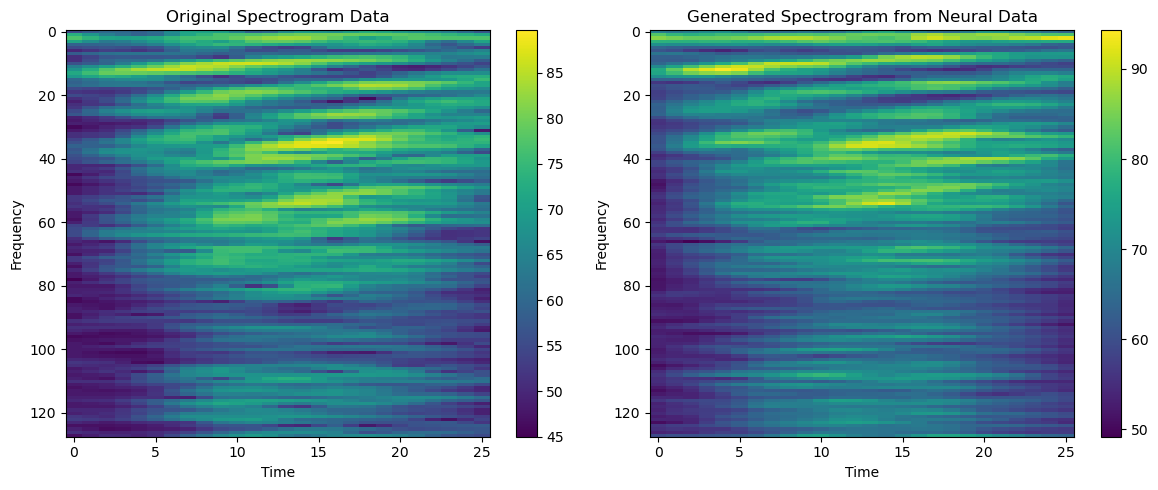

In [427]:
plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.imshow(speech_data.cpu().numpy(), aspect='auto', cmap='viridis')
plt.colorbar()
plt.title('Original Spectrogram Data')
plt.xlabel('Time')
plt.ylabel('Frequency')

plt.subplot(122)
plt.imshow(generated_speech.cpu().numpy(), aspect='auto', cmap='viridis')
plt.colorbar()
plt.title('Generated Spectrogram from Neural Data')
plt.xlabel('Time')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

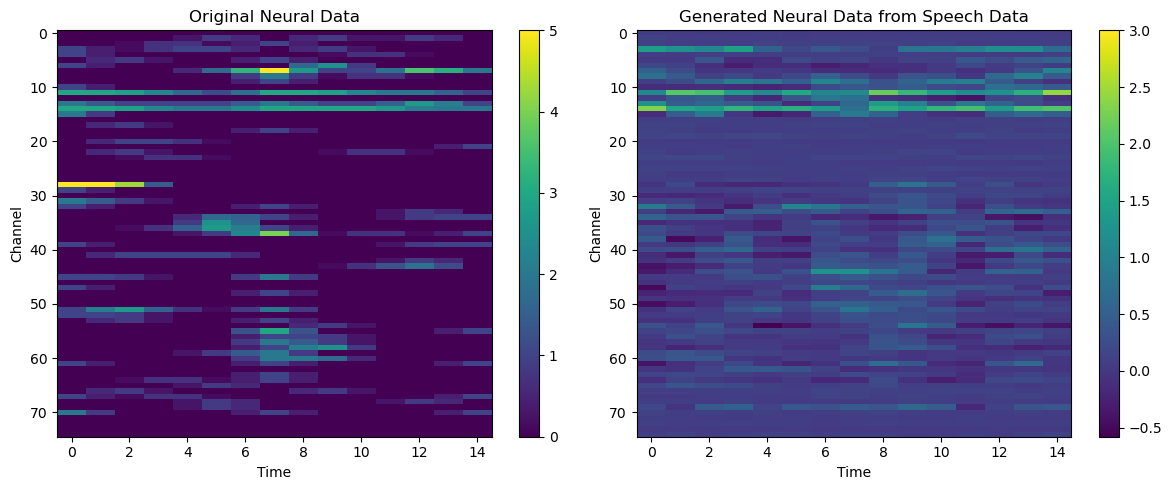

In [370]:
# plt.figure(figsize=(12, 5))

# plt.subplot(121)
# plt.imshow(speech_data.cpu().numpy(), aspect='auto', cmap='viridis')
# plt.colorbar()
# plt.title('Original Neural Data')
# plt.xlabel('Time')
# plt.ylabel('Channel')

# plt.subplot(122)
# plt.imshow(generated_speech.cpu().numpy(), aspect='auto', cmap='viridis', vmax=3)
# plt.colorbar()
# plt.title('Generated Neural Data from Speech Data')
# plt.xlabel('Time')
# plt.ylabel('Channel')

# plt.tight_layout()
# plt.show()